In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import copy
import sys
import time

import numpy as np

from sklearn.metrics import mean_absolute_error

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Crippen import MolLogP

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm_notebook
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.seed = 123
args.val_size = 0.1
args.test_size = 0.1
args.shuffle = True

In [4]:
np.random.seed(args.seed)
torch.manual_seed(args.seed)

In [5]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

# 1. Pre-Processing

In [6]:
def read_ZINC_smiles(file_name, num_mol):
    f = open(file_name, 'r')
    contents = f.readlines()

    smi_list = []
    logP_list = []

    for i in tqdm_notebook(range(num_mol), desc='Reading Data'):
        smi = contents[i].strip()
        m = Chem.MolFromSmiles(smi)
        smi_list.append(smi)
        logP_list.append(MolLogP(m))

    logP_list = np.asarray(logP_list).astype(float)

    return smi_list, logP_list

def smiles_to_onehot(list_smiles):
    def smiles_to_vector(smiles, vocab, max_length):
        while len(smiles) < max_length:
            smiles += " "
        vector = [vocab.index(str(x)) for x in smiles]
        onehot = np.zeros((max_length, len(vocab)), dtype=float)
        for i, elm in enumerate(vector):
            onehot[i][elm] = 1.0
        return onehot

    vocab = np.load('./vocab.npy')
    onehot_total = list()
    length_total = list()
    for smiles in tqdm_notebook(list_smiles, desc='Converting Data'):
        onehot = smiles_to_vector(smiles, list(vocab), 120)
        onehot_total.append(onehot)
        length_total.append(len(smiles))
    
    return np.asarray(onehot_total), np.asarray(length_total)

In [7]:
class RNNDataset(Dataset):

    def __init__(self, list_smiles, list_length, list_logP):
        self.list_smiles = list_smiles
        self.list_length = list_length
        self.list_logP = list_logP

    def __len__(self):
        return len(self.list_smiles)

    def __getitem__(self, index):
        return self.list_smiles[index], self.list_length[index], self.list_logP[index]
    

def partition(list_onehot, list_length, list_logP, args):
    num_total = list_onehot.shape[0]
    num_val = int(num_total * args.val_size)
    num_test = int(num_total * args.test_size)
    num_train = num_total - (num_val + num_test)

    onehot_train = list_onehot[:num_train]
    length_train = list_length[:num_train]
    logP_trian = list_logP[:num_train]

    onehot_val = list_onehot[num_train:num_train+num_val]
    length_val = list_length[num_train:num_train+num_val]
    logP_val = list_logP[num_train:num_train+num_val]

    onehot_test = list_onehot[num_total-num_test:]
    length_test = list_length[num_total-num_test:]
    logP_test = list_logP[num_total-num_test:]

    train_set = RNNDataset(onehot_train, length_train, logP_trian)
    val_set = RNNDataset(onehot_val, length_val, logP_val)
    test_set = RNNDataset(onehot_test, length_test, logP_test)

    partition = {
        'train': train_set,
        'val': val_set,
        'test': test_set
    }

    return partition

In [8]:
list_smiles, list_logP = read_ZINC_smiles("ZINC.smiles", 10000)
list_onehot, list_length = smiles_to_onehot(list_smiles)
dict_partition = partition(list_onehot, list_length, list_logP, args)

# 2. Model Construction

In [26]:
class RNNBlock(nn.Module):

    def __init__(self, in_dim, hidden_dim, batch_size, num_layer=1, dropout=0):
        super(RNNBlock, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layer = num_layer
        
        self.lstm = nn.LSTM(in_dim, hidden_dim, num_layer, dropout)
        self.h_in = nn.Parameter(torch.randn(num_layer, batch_size, hidden_dim))
        self.c_in = nn.Parameter(torch.randn(num_layer, batch_size, hidden_dim))

    def forward(self, onehot, length):
        #batch_size = onehot.shape[0]
        
        #h_in = nn.Parameter(torch.randn(self.num_layer, batch_size, self.hidden_dim).cuda())
        #c_in = nn.Parameter(torch.randn(self.num_layer, batch_size, self.hidden_dim).cuda())
        packed = nn.utils.rnn.pack_padded_sequence(onehot, length, batch_first=True)
        
        output, (h_out, c_out) = self.lstm(packed, (self.h_in, self.c_in))
        #unpacked, unpacked_length = nn.utils.rnn.pad_packed_sequence(output, batch_first=True)
        #vectors = list()
        #for i, vector in enumerate(unpacked):
        #    vectors.append(unpacked[i, unpacked_length[i]-1, :].view(1, -1))
        #out = nn.Parameter(torch.cat(vectors, 0).cuda())
        return output, (h_out, c_out)

In [10]:
class Predictor(nn.Module):

    def __init__(self, in_dim, out_dim, act=None):
        super(Predictor, self).__init__()

        self.linear = nn.Linear(in_dim, out_dim)
        nn.init.xavier_normal_(self.linear.weight)
        self.activation = act

    def forward(self, x):
        out = self.linear(x)
        if self.activation != None:
            out = self.activation(out)
        return out

In [11]:
class RNNNet(nn.Module):
    
    def __init__(self, args):
        super(RNNNet, self).__init__()

        self.rnnBlock = RNNBlock(args.in_dim, args.hidden_dim, args.num_layer, args.dropout)
        self.pred1 = Predictor(args.hidden_dim, args.pred_dim1, act=nn.ReLU())
        self.pred2 = Predictor(args.pred_dim1, args.pred_dim2, act=nn.ReLU())
        self.pred3 = Predictor(args.pred_dim2, args.out_dim)

    def forward(self, onehot, length):
        out = self.rnnBlock(onehot, length)
        out = self.pred1(out)
        out = self.pred2(out)
        out = self.pred3(out)
        return out

# 3. Train, Validate, and Test

In [21]:
def train(model, device, optimizer, criterion, data_train, bar, args):
    for i, batch in enumerate(data_train):
        list_onehot = torch.tensor(batch[0]).cuda().float()
        list_length = torch.tensor(batch[1]).cuda()
        list_logP = torch.tensor(batch[2]).cuda().float()
        # Sort onehot tensor with respect to the sequence length.
        list_length, list_index = torch.sort(list_length, descending=True)
        list_length.cuda()
        list_index.cuda()
        list_onehot = torch.Tensor([list_onehot.tolist()[i] for i in list_index]).cuda().float()

        model.train()
        optimizer.zero_grad()

In [22]:
def validate(model, device, criterion, data_val, bar, args):
    epoch_val_loss = 0
    epoch_val_mae = 0

    with torch.no_grad():
        for i, batch in enumerate(data_val):
            list_onehot = torch.tensor(batch[0]).cuda().float()
            list_length = torch.tensor(batch[1]).cuda()
            list_logP = torch.tensor(batch[2]).cuda().float()

            # Sort onehot tensor with respect to the sequence length.
            list_length, list_index = torch.sort(list_length, descending=True)
            list_length.cuda()
            list_index.cuda()
            list_onehot = torch.Tensor([list_onehot.tolist()[i] for i in list_index]).cuda().float()

            model.eval()
            list_pred_logP = model(list_onehot, list_length).squeeze().cuda()
            list_pred_logP.require_grad = False

            val_loss = criterion(list_pred_logP, list_logP)
            val_mae = mean_absolute_error(list_pred_logP.tolist(), list_logP.tolist())
            epoch_val_loss += val_loss.item()
            epoch_val_mae += val_mae

            bar.update(len(list_onehot))

    epoch_val_loss /= len(data_val)
    epoch_val_mae /= len(data_val)
    
    return model, epoch_val_loss, epoch_val_mae

In [23]:
def test(model, device, data_test, args):
    model.eval()
    with torch.no_grad():
        pred_logP_total = list()
        logP_total = list()
        for i, batch in enumerate(data_test):
            list_onehot = torch.tensor(batch[0]).cuda().float()
            list_length = torch.tensor(batch[1]).cuda()
            list_logP = torch.tensor(batch[2]).cuda().float()

            # Sort onehot tensor with respect to the sequence length.
            list_length, list_index = torch.sort(list_length, descending=True)
            list_length.cuda()
            list_index.cuda()
            list_onehot = torch.Tensor([list_onehot.tolist()[i] for i in list_index]).cuda().float()

            list_pred_logP = model(list_onehot, list_length).squeeze().cuda()

            pred_logP_total += list_pred_logP.tolist()
            logP_total += list_logP.tolist()

        mae = mean_absolute_error(logP_total, pred_logP_total)
        std = np.std(np.array(logP_total) - np.array(pred_logP_total))

    return mae, std, logP_total, pred_logP_total

In [15]:
def experiment(dict_partition, device, bar, args):
    time_start = time.time()

    model = RNNNet(args)
    model.cuda()

    if args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    elif args.optim == 'SGD':
        optimizer = optim.SGD(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    else:
        assert False, 'Undefined Optimizer Type'

    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.step_size, gamma=args.gamma)

    list_train_loss = list()
    list_val_loss = list()
    list_train_mae = list()
    list_val_mae = list()

    data_train = DataLoader(dict_partition['train'], batch_size=args.batch_size, shuffle=args.shuffle)
    data_val = DataLoader(dict_partition['val'], batch_size=args.batch_size, shuffle=args.shuffle)

    for epoch in range(args.epoch):
        scheduler.step()
        
        model, train_loss, train_mae = train(model, device, optimizer, criterion, data_train, bar, args)
        list_train_loss.append(train_loss)
        list_train_mae.append(train_mae)

        mode, val_loss, val_mae = validate(model, device, criterion, data_val, bar, args)
        list_val_loss.append(val_loss)
        list_val_mae.append(val_mae)

    data_test = DataLoader(dict_partition['test'], batch_size=args.batch_size, shuffle=args.shuffle)

    mae, std, logP_total, pred_logP_total = test(model, device, data_test, args)

    time_end = time.time()
    time_required = time_end - time_start

    args.list_train_loss = list_train_loss
    args.list_val_loss = list_val_loss
    args.list_train_mae = list_train_mae
    args.list_val_mae = list_val_mae
    args.logP_total = logP_total
    args.pred_logP_total = pred_logP_total
    args.mae = mae
    args.std = std
    args.time_required = time_required

    return args

# 4. Visualization

In [16]:
def plot_performance(df_result, var1, var2):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    
    df_mae = df_result.pivot(var1, var2, 'mae')
    df_std = df_result.pivot(var1, var2, 'std')
    df_mae = df_mae[df_mae.columns].astype(float)
    df_std = df_std[df_std.columns].astype(float)
    
    hm_mae = sns.heatmap(df_mae, ax=ax[0], annot=True, fmt='f', linewidths=.5, cmap='YlGnBu')
    hm_std = sns.heatmap(df_std, ax=ax[1], annot=True, fmt='f', linewidths=.5, cmap='YlGnBu')
    
    fig.suptitle('Performance depends on ' + var1 + ' vs ' + var2)
    hm_mae.set_title('MAE depends on ' + var1 + ' vs ' + var2)
    hm_std.set_title('Std depends on ' + var1 + ' vs ' + var2)

In [17]:
def plot_performance_bar(df_result, var1, var2):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    bar_mae = sns.barplot(x=var1, y='mae', hue=var2, data=df_result, ax=ax[0])
    bar_std = sns.barplot(x=var1, y='std', hue=var2, data=df_result, ax=ax[1])
    
    bar_mae.set_title('MAE depends on ' + var1 + ' vs ' + var2)
    bar_std.set_title('Std depends on ' + var1 + ' vs ' + var2)
    fig.suptitle('Performance depends on ' + var1 + ' vs ' + var2)

In [18]:
def plot_loss(df_result, var1, var2, ylim):
    def plot(x, ylim=1.0, **kwargs):
        plt.plot(x[0], **kwargs)
        plt.ylim(0.0, ylim)
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    g = sns.FacetGrid(df_result, row=var1, col=var2, margin_titles=True)
    g.map(plot, 'list_train_loss', ylim=ylim, label='Train Loss')
    g.map(plot, 'list_val_loss', ylim=ylim, color='r', label='Validation Loss')
    g.fig.suptitle('Loss vs Epochs depends on ' + var1 + ' vs ' + var2, size=16)
    g.fig.subplots_adjust(top=.9)
    plt.legend()
    plt.show()

In [19]:
def plot_distribution(df_result, var1, var2):
    def scatter(x, y, **kwargs):
        plt.scatter(x[0], y[0], alpha=0.3, s=2)
    def identity(x, y, **kwargs):
        plt.plot(x[0], x[0], alpha=0.4, color='black')
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    g = sns.FacetGrid(df_result, row=var1, col=var2, margin_titles=True)
    g.map(scatter, 'logP_total', 'pred_logP_total')
    g.map(identity, 'logP_total', 'logP_total')
    g.fig.suptitle('Truth Distribution depends on ' + var1 + ' vs ' + var2, size=16)
    g.fig.subplots_adjust(top=.9)
    plt.show()

# 5. Experiment

In [24]:
args.batch_size = 128
args.lr = 0.001
args.l2_coef = 0
args.optim = 'Adam'
args.epoch = 5
args.num_layer = 1
args.dropout = 0
args.in_dim = 32
args.hidden_dim = 64
args.pred_dim1 = 128
args.pred_dim2 = 64
args.out_dim = 1
args.step_size = 10
args.gamma = 1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [25]:
dict_result = dict()
n_iter = args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

args.exp_name = "test"
result = vars(experiment(dict_partition, device, bar, args))
dict_result[args.exp_name] = copy.deepcopy(result)

torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('test.JSON', orient='table')

MAE: 1.0262372623
Std: 1.3049317558


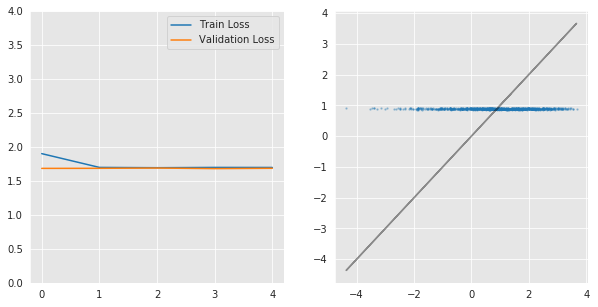

In [30]:
df_result = pd.read_json('test.JSON', orient='table')

print("MAE: " + str(df_result['mae'][0]))
print("Std: " + str(df_result['std'][0]))

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

ax[0].plot(df_result['list_train_loss'][0], label='Train Loss')
ax[0].plot(df_result['list_val_loss'][0], label='Validation Loss')
ax[0].set_ylim([0, 4])
ax[0].legend()
ax[1].scatter(df_result['logP_total'][0], df_result['pred_logP_total'][0], alpha=0.3, s=2)
ax[1].plot(df_result['logP_total'][0], df_result['logP_total'][0], color='black', alpha=0.4)

In [28]:
df_result['list_val_loss']

test    [1.6838671714, 1.6848644167, 1.688664391600000...
Name: list_val_loss, dtype: object

In [51]:
vocab = list(np.load('./vocab.npy'))
smiles = "C(=O)Cl"
smiles_onehot = [vocab.index(str(x)) for x in smiles]
print(vocab)

[' ', 'c', 'C', '(', ')', 'O', '1', '2', 'N', '=', '[', ']', '@', '3', 'H', 'n', '4', 'F', '+', 'S', 'l', 's', '/', 'o', '-', '5', '#', 'B', 'r', '\\', '6', 'I']


In [54]:
print(list_onehot[1])
print(list_length)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
[22 20 23 26 30 24 33 33 24 29 21 22 22 24 37 30 27 34 37 41 33 30 28 27
 32 26 30 28 26 26 28 32 26 25 29 37 21 24 21 26 36 33 30 29 33 23 31 29
 34 35 40 25 29 34 26 32 17 25 25 30 17 38 27 26 31 36 37 27 30 27 33 31
 27 12 17 30 22 27 24 31 25 37 29 31 32 27 29 27 15 35 11 36 32 28 35 28
 29 29 20 31 31 30 31 28 31 26 29 28 27 17 23 16 24 34 30 32 27 28 17 30
 25 32 26 26 24 19 25 31 25 24 34 25 30 19 27 30 27 27 24 31 25 22 31 31
 31 31 23 37 27 26 25 30 21 24 29 33 38 20 33 24 33 22 26 28 25 28 31 26
 23 32 21 34 35 30 19 35 31 30 35 36 29 30 21 33 36 28 28 30 29 26 29 22
 21 19 23 36 33 33 27 24 33 26 30 32 31 35 38 25 25 25 22 32 14 27 26 31
 36 32 31 33 32 35 28 22 25 26 33 14 30 15 14 22 28 27 32 31 31 27 24 28
 26 26 22 16 29 28 28 31 35 34 24 29 29 21 35 36 24 27 23 20 22 16 21 26
 24 30 30 35 33 33 27 28 21 25 32 28 26 2

In [73]:
tensor_onehot = torch.Tensor(list_onehot[:5])
tensor_length = torch.Tensor(list_length[:5])
print(tensor_length)
tensor_length, tensor_index = torch.sort(tensor_length, descending=True)
tensor_onehot, tensor_length, tensor_index

tensor([22., 20., 23., 26., 30.])


(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 1.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [1., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 1.,  ..., 0., 0., 0.],
          [0., 0., 1.,  ..., 0., 0., 0.],
          [0., 0., 1.,  ..., 0., 0., 0.],
          ...,
          [1., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 1.,  ..., 0., 0., 0.],
          [0., 0., 1.,  ..., 0., 0., 0.],
          [0., 0., 1.,  ..., 0., 0., 0.],
          ...,
          [1., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 1.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [1., 0., 0.,  ..., 0., 0., 0.],
       

In [72]:
#tensor_onehot = tensor_onehot.tolist()
tensor_onehot = torch.Tensor([tensor_onehot.tolist()[i] for i in tensor_index])
tensor

tensor([[[0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 

In [39]:
lstm = nn.LSTM(2, 128, 1)

In [40]:
input1 = torch.Tensor([[[1, 2], [2, 3], [3, 4], [4, 5]]])
lstm(input1)[0].shape

torch.Size([1, 4, 128])

In [37]:
input2 = torch.Tensor([[[1], [2], [3], [4], [5]]])

lstm(input2)[0].shape

torch.Size([1, 5, 128])

In [255]:
args.batch_size = 128
args.in_dim = 32
args.hidden_dim = 64
args.out_dim = 1
args.pred_dim1 = 128
args.pred_dim2 = 64
args.num_layer = 2
args.dropout = 0

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [28]:
model = RNNNet(args)
model.cuda()

data_train = DataLoader(dict_partition['train'],
                        batch_size=args.batch_size,
                        shuffle=args.shuffle)

for i, batch in enumerate(data_train):
    if i==0:
        list_onehot = torch.tensor(batch[0]).cuda()
        list_length = torch.tensor(batch[1]).cuda()
        list_logP = torch.tensor(batch[2]).cuda().view(-1, 1).float()
        
        # Sort onehot tensor with respect to the sequence length.
        list_length, list_index = torch.sort(list_length, descending=True)
        list_onehot = torch.Tensor([list_onehot.tolist()[i] for i in list_index])

        list_pred_logP = model(list_onehot, list_length).to(device)
        list_pred_logP.require_grad = False

In [257]:
list_pred_logP.shape

torch.Size([128, 1])

In [258]:
mse = nn.MSELoss()
mse(list_pred_logP, list_logP)

tensor(3.0005, grad_fn=<MseLossBackward>)

In [259]:
list_pred_logP = list_pred_logP.squeeze()
list_logP = list_logP.squeeze()
mse(list_pred_logP, list_logP)

tensor(3.0005, grad_fn=<MseLossBackward>)

In [260]:
np.std(np.array(list_pred_logP.tolist())-np.array(list_logP.tolist()))

1.3664387083612617

In [261]:
mean_absolute_error(np.array(list_pred_logP.tolist()), np.array(list_logP.tolist()))

1.4918543050880544